In [0]:
#importing libraries

import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import datetime
import re, nltk
nltk.download('punkt')
nltk.download('stopwords')  
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer 
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.metrics.pairwise import cosine_similarity


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
df = pd.read_csv('metadata.csv')
print(df.shape)
df.head()

(45774, 17)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file,url
0,vho70jcx,f056da9c64fbf00a4645ae326e8a4339d015d155,biorxiv,SIANN: Strain Identification by Alignment to N...,10.1101/001727,NaN,NaN,biorxiv,Next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/001727
1,i9tbix2v,daf32e013d325a6feb80e83d15aabc64a48fae33,biorxiv,Spatial epidemiology of networked metapopulati...,10.1101/003889,NaN,NaN,biorxiv,An emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/003889
2,62gfisc6,f33c6d94b0efaa198f8f3f20e644625fa3fe10d2,biorxiv,Sequencing of the human IG light chain loci fr...,10.1101/006866,NaN,NaN,biorxiv,Germline variation at immunoglobulin gene (IG)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/006866
3,058r9486,4da8a87e614373d56070ed272487451266dce919,biorxiv,Bayesian mixture analysis for metagenomic comm...,10.1101/007476,NaN,NaN,biorxiv,Deep sequencing of clinical samples is now an ...,2014-07-25,Sofia Morfopoulou; Vincent Plagnol,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/007476
4,wich35l7,eccef80cfbe078235df22398f195d5db462d8000,biorxiv,Mapping a viral phylogeny onto outbreak trees ...,10.1101/010389,NaN,NaN,biorxiv,Developing methods to reconstruct transmission...,2014-11-11,Stephen P Velsko; Jonathan E Allen,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/010389


# 1. Data Cleaning

In [0]:
# keeping useful features and dropping empty/duplicate row entries
df = df[['title','abstract','authors','publish_time']]
df = df.drop_duplicates(subset='abstract', keep="first")
df=df.dropna()
df["abstract"] = df["abstract"].str.lower()
print(df.shape)
df.head()

(37252, 4)


,title,abstract,authors,publish_time
0,SIANN: Strain Identification by Alignment to N...,next-generation sequencing is increasingly bei...,Samuel Minot; Stephen D Turner; Krista L Ternu...,2014-01-10
1,Spatial epidemiology of networked metapopulati...,an emerging disease is one infectious epidemic...,Lin WANG; Xiang Li,2014-06-04
2,Sequencing of the human IG light chain loci fr...,germline variation at immunoglobulin gene (ig)...,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,2014-07-03
3,Bayesian mixture analysis for metagenomic comm...,deep sequencing of clinical samples is now an ...,Sofia Morfopoulou; Vincent Plagnol,2014-07-25
4,Mapping a viral phylogeny onto outbreak trees ...,developing methods to reconstruct transmission...,Stephen P Velsko; Jonathan E Allen,2014-11-11


# 2. Data Visualization and Exploratory Data Analysis

## 2.1 Visualizing Paper Authors

To ensure that the papers used in the analysis are published by experienced authors, we will filter through the dataset to retrieve papers that are published by authors who have published at least 2 papers within the same dataset. To do so, we will first analyze some basic informations about the paper authors:

- A total of roughly 160,000 unique authors have published or is part of the roughly 37,000 papers in this dataset. 

- The author with the highest number of papers under his/her name has published or is part of 141 papers. 

- The top 7 authors all have published over 100 papers each.


From exploring the author information, it is determined that the top 30,000 authors all have published at least 2 papers each, so we will only consider papers that is published by these authors. As a result, 27,033 papers (out of 37,252) are included in the analysis

Note that a paper is included if at least one of its authors (if written by multiple people) is part of the top 30,000 authors. Also note that due to limited information, we will combine authors with duplicate names (i.e. different authors with the same name) when accounting for unique authors in the dataset. 

In [0]:
# getting author names mentioned in all papers
author_list = []

for i in range(len(df)):

  authors = df['authors'].iloc[i]
  split = authors.split(';')
  author_list.append(split)

flat_list = [author for sublist in author_list for author in sublist]

In [0]:
# total number of authors (including duplicates)
len(flat_list)

237104

In [0]:
# number of unique authors (authors with duplicate names are combined)
len(set(flat_list))

160516

In [0]:
# top 30,000 authors with the most number of papers published
common_authors = Counter(flat_list).most_common(30000)

In [0]:
# authors in this list have published at least 2 papers each
common_authors[-5:]

[('Gunson, R.N.', 2),
 ('Bialasiewicz, S.', 2),
 (' Rognlien, Anne Gro Wesenberg', 2),
 ('Fox, Julie D.', 2),
 ('Minosse, C.', 2)]

Text(0.5, 1.0, 'Number of Papers Published by the Top 30,000 Authors')

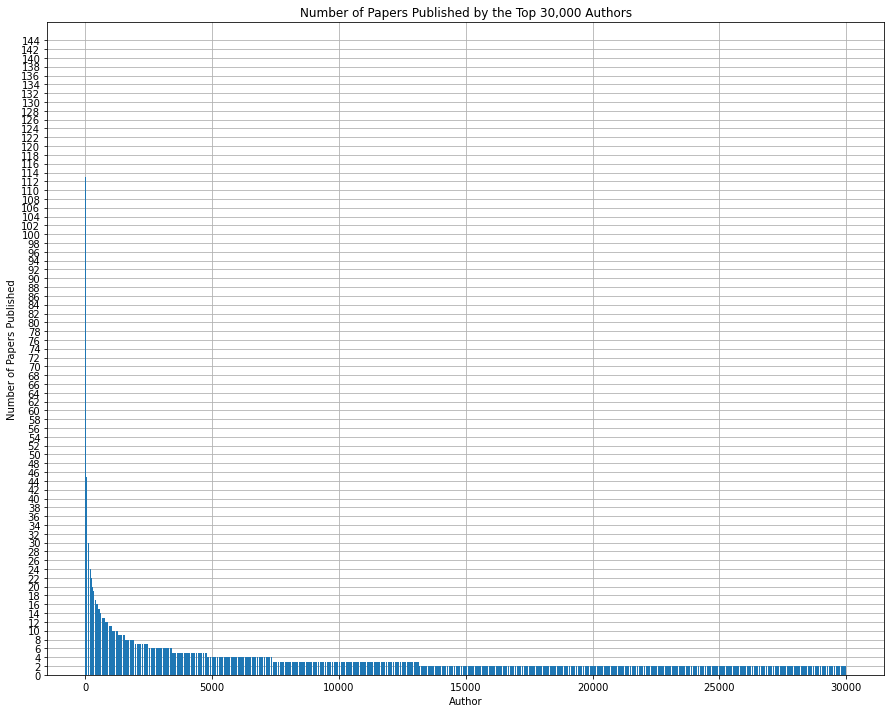

In [0]:
# plotting number of papers published by top 30,000 authors 
names = []
count = []

for i in range(len(common_authors)):

  names.append(common_authors[i][0])
  count.append(common_authors[i][1])

figure(figsize=(15, 12))
plt.grid(zorder=0)
plt.bar(list(range(len(names))), count, align='center', zorder=3)
plt.yticks(np.linspace(0,144, 73))
plt.xlabel('Author')
plt.ylabel('Number of Papers Published')
plt.title('Number of Papers Published by the Top 30,000 Authors')

In [0]:
# number of papers published by top 10 authors based on frequency
count[:10]

[141, 134, 129, 124, 115, 113, 101, 91, 82, 78]

In [0]:
# filtering for papers published by the top 30,000 authors
df_filter = pd.DataFrame(columns=['title','abstract','authors','publish_time'])

for i in range(len(df)):

  authors = df['authors'].iloc[i]
  split = authors.split(';')
  check = [split[j] in names for j in range(len(split))]

  # the paper will be included if at least one of the authors of the paper is in the top 30,000
  if True in check:
    df_filter.loc[i] = df.iloc[i]

  else:
    pass

In [0]:
df_filter.reset_index()

,index,title,abstract,authors,publish_time
0,1,Spatial epidemiology of networked metapopulati...,an emerging disease is one infectious epidemic...,Lin WANG; Xiang Li,2014-06-04
1,5,The infant airway microbiome in health and dis...,the nasopharynx (np) is a reservoir for microb...,Shu Mei Teo; Danny Mok; Kym Pham; Merci Kusel;...,2014-12-02
2,7,"Big city, small world: Density, contact rates,...",macroscopic descriptions of populations common...,Moritz U. G. Kraemer; T. Alex Perkins; Derek A...,2015-04-27
3,8,MERS-CoV recombination: implications about the...,recombination is a process that unlinks neighb...,Gytis Dudas; Andrew Rambaut,2015-06-12
4,10,Viruses are a dominant driver of protein adapt...,viruses interact with hundreds to thousands of...,David Enard; Le Cai; Carina Gwenapp; Dmitri A ...,2015-10-18
...,...,...,...,...,...
27028,37246,Relative immunogenicity and protection potenti...,"summary yersinia pestis outer proteins, plasmi...","Wang, Shixia; Joshi, Swati; Mboudjeka, Innocen...",2008-03-20
27029,37248,Personal Protective Equipment: Protecting Heal...,abstract purpose the recent ebola epidemic tha...,"Fischer, William A.; Weber, David J.; Wohl, Da...",2015-11-01
27030,37249,Viruses and asthma,abstract background viral respiratory infectio...,"Dulek, Daniel E.; Peebles, R. Stokes",2011-11-30
27031,37250,Why the WHO won't use the p-word,"there are no criteria for a pandemic, but covi...","MacKenzie, Debora",2020-03-07


In [0]:
# number of papers after filtering for the top 20,000 authors
len(df_filter)

27033

## 2.2 Visualizing Paper Year

To ensure that the medical data is likely up-to-date, we will analyze and determine the proportions of paper that are likely out-dated. Based on the exploratory analysis below, the following is determined: 

- There are 55 years in consideration from 1955 to 2020, with gap years before 2000 in which there is not data available.

- The 10 years with the least number of papers published are before 1975, with a total of 46 papers published.

- There is a graudal increase in number of papers published every year starting in the 2000's. 

- There are almost 2,000 published papers in 2019, compared to 2010 which had a little over 1,000 (almost 2-fold increase in a decade). 

As a result, we will exclude the papers published before 1975 considering their low numbers as well as dated nature. The result df contains 26,987 papers.

In [0]:
df_filter['publish_time'] = pd.to_datetime(df_filter['publish_time'], format='%Y-%m-%d')
df_filter['publish_year'] = pd.DatetimeIndex(df_filter['publish_time']).year
year_count = Counter(df_filter['publish_year'])

In [0]:
df_filter.head()

,title,abstract,authors,publish_time,publish_year
1,Spatial epidemiology of networked metapopulati...,an emerging disease is one infectious epidemic...,Lin WANG; Xiang Li,2014-06-04,2014
5,The infant airway microbiome in health and dis...,the nasopharynx (np) is a reservoir for microb...,Shu Mei Teo; Danny Mok; Kym Pham; Merci Kusel;...,2014-12-02,2014
7,"Big city, small world: Density, contact rates,...",macroscopic descriptions of populations common...,Moritz U. G. Kraemer; T. Alex Perkins; Derek A...,2015-04-27,2015
8,MERS-CoV recombination: implications about the...,recombination is a process that unlinks neighb...,Gytis Dudas; Andrew Rambaut,2015-06-12,2015
10,Viruses are a dominant driver of protein adapt...,viruses interact with hundreds to thousands of...,David Enard; Le Cai; Carina Gwenapp; Dmitri A ...,2015-10-18,2015


In [0]:
# bottom 10 years with the least publications
year_count.most_common()[-10:]

[(1975, 11),
 (1973, 8),
 (1970, 7),
 (1972, 7),
 (1974, 5),
 (1971, 4),
 (1955, 1),
 (1957, 1),
 (1967, 1),
 (1969, 1)]

In [0]:
# top 20 years with the most publications
year_count.most_common(20)

[(2019, 2114),
 (2018, 2088),
 (2016, 1954),
 (2017, 1939),
 (2015, 1891),
 (2014, 1746),
 (2020, 1708),
 (2013, 1605),
 (2012, 1446),
 (2011, 1356),
 (2010, 1215),
 (2009, 1127),
 (2008, 967),
 (2007, 848),
 (2006, 766),
 (2005, 714),
 (2004, 624),
 (2003, 284),
 (1991, 164),
 (1995, 152)]

Text(0.5, 1.0, 'Number of Papers Published by Year')

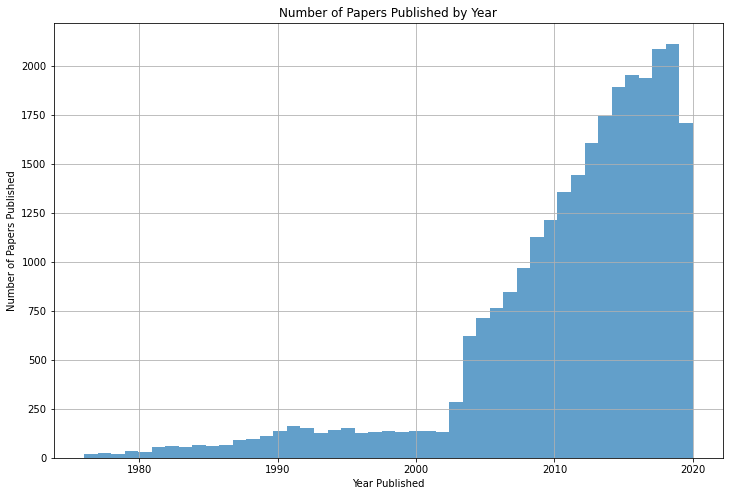

In [0]:
figure(figsize=(12, 8))
plt.hist(list(df_filter['publish_year']), bins=45, alpha=0.7)
plt.grid(zorder=0)
plt.xlabel('Year Published')
plt.ylabel('Number of Papers Published')
plt.title('Number of Papers Published by Year')

In [0]:
# excluding papers published before 1975
df_filter = df_filter[df_filter.publish_year > 1975]
len(df_filter)

26987

## 2.3 Visualizing Risk Factors

The following risk factors are collected from online resources including scientific papers and news journals. 

The risk factors then presented into the columns of a dataframe, where the rows are each paper abstract containing/not containing each risk factor (1 or 0). After all the papers have been checked, the number of each risk factor is counted and presented in a horizontal bar chart. 

From the bar plot, we can observe that the word 'respiratory' occurs in many more paper abstracts than the other words, indicating that this is a significant risk factor. Also, the word male appears in more papers than female, suggesting that males may be more susceptible to this virus.

Note that the risk factor immune deficiency is dropped from the dataframe since it does not appear in any paper abstract. 

In [0]:
# defining common fatality risk factors of coronavirus from research
risk_factors = ['male', 'female', 'age', 'hypertension', 'heart', 'cardiovascular',
                'kidney', 'liver', 'lung', 'respiratory', 'immune deficiency', 'cancer', 'chemotherapy',
                'hiv', 'aids', 'transplant', 'immunocompromised', 'smoking', 'alcohol', 'obesity',
                'corticosteroids','leukemia']

In [0]:
# search through the abstract of every paper, 1 for risk factor in abstract, 0 for otherwise
abstract = df_filter['abstract'].tolist()
df_rows = []
ps = PorterStemmer()

for entry in abstract:
  
  word_tokens = word_tokenize(entry)
  stemmed = [ps.stem(word) for word in word_tokens]
  df_rows.append([1 if ps.stem(factor) in stemmed else 0 for factor in risk_factors])


In [0]:
df_risk = pd.DataFrame(df_rows, columns=risk_factors)
df_risk.head()

,male,female,age,hypertension,heart,cardiovascular,kidney,liver,lung,respiratory,immune deficiency,cancer,chemotherapy,hiv,aids,transplant,immunocompromised,smoking,alcohol,obesity,corticosteroids,leukemia
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
df_risk.shape

(26987, 22)

In [0]:
count = df_risk.sum()
count

male                  496
female                396
age                  2148
hypertension          122
heart                 247
cardiovascular        140
kidney                553
liver                 637
lung                 1613
respiratory          7492
immune deficiency       0
cancer                631
chemotherapy           70
hiv                   502
aids                  396
transplant            315
immunocompromised     231
smoking                98
alcohol                53
obesity                62
corticosteroids       149
leukemia              182
dtype: int64

Text(0.5, 1.0, 'Number of Paper Abstracts Containing Each Risk Factor')

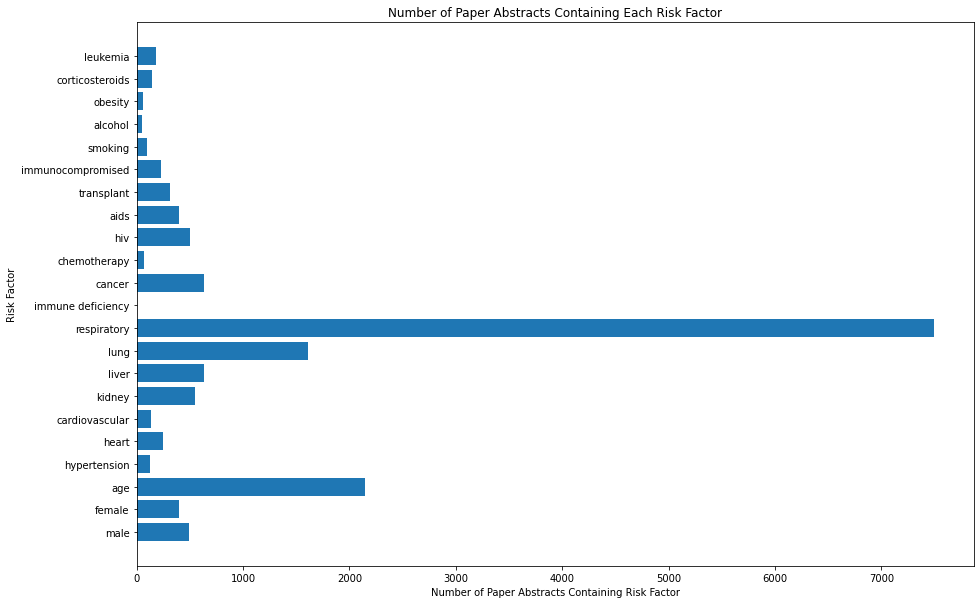

In [0]:
figure(figsize=(15,10))
plt.barh(risk_factors, count)
plt.xlabel('Number of Paper Abstracts Containing Risk Factor')
plt.ylabel('Risk Factor')
plt.title('Number of Paper Abstracts Containing Each Risk Factor')

In [0]:
# dropping the risk factor that is never mentioned in paper abstracts
df_risk = df_risk.loc[:, (df_risk != 0).any(axis=0)]

In [0]:
# rest of risk factors
df_risk.shape

(26987, 21)

# 3. Model Selection and Fitting to Data

To carry forward our analysis, we will choose unsupervised learning methods to interpret the coronavirus risk factors as defined above. Specifically, we will use hierarchical agglomerative clustering to group these risk factors.

## 3.1 Euclidean Distance

To calculate the pairwise distance between each pair of risk factors, we will first investigate the suitability of Euclidean distance as a similarity metric for our data. We will also explore different linkage criterias for the clustering algorithm. 

In [0]:
# calculates pairwise euclidean distance and forms the distance matrix
euclidean = pd.DataFrame(
    squareform(pdist(df_risk.T)),
    columns = df_risk.T.index,
    index = df_risk.T.index)

euclidean

,male,female,age,hypertension,heart,cardiovascular,kidney,liver,lung,respiratory,cancer,chemotherapy,hiv,aids,transplant,immunocompromised,smoking,alcohol,obesity,corticosteroids,leukemia
male,0.000000,22.226111,46.238512,24.083189,26.400758,24.819347,31.796226,33.030289,44.710178,87.223850,33.241540,23.790755,31.368774,29.664794,28.337255,26.888659,24.041631,23.302360,23.494680,25.079872,25.573424
female,22.226111,0.000000,46.432747,22.226111,24.758837,22.847319,30.380915,31.448370,43.897608,87.429972,31.796226,21.587033,29.664794,27.820855,26.627054,24.919872,22.000000,21.189620,21.260292,23.130067,23.790755
age,46.238512,46.432747,0.000000,46.690470,47.549974,47.116876,51.176166,51.951901,59.050826,85.941841,52.067264,46.882833,51.068581,50.059964,49.040799,48.218254,46.561787,46.872167,46.711883,47.106263,48.020829
hypertension,24.083189,22.226111,46.690470,0.000000,17.233688,14.071247,25.079872,27.367864,41.000000,86.740994,27.184554,13.856406,24.979992,22.715633,20.808652,18.734994,14.352700,13.076697,12.884099,16.340135,17.435596
heart,26.400758,24.758837,47.549974,17.233688,0.000000,17.860571,26.944387,28.495614,41.809090,87.080423,28.982753,17.804494,27.294688,25.278449,23.237900,21.633308,18.138357,17.204651,17.117243,19.646883,20.712315
cardiovascular,24.819347,22.847319,47.116876,14.071247,17.860571,0.000000,25.514702,27.513633,41.315857,86.890736,27.221315,14.491377,25.298221,23.021729,21.189620,19.157244,15.165751,13.747727,13.341664,16.881943,17.944358
kidney,31.796226,30.380915,51.176166,25.079872,26.944387,25.514702,0.000000,31.685959,44.158804,88.266641,34.000000,24.919872,32.264532,30.610456,28.740216,27.748874,25.396850,24.576411,24.596748,26.419690,26.814175
liver,33.030289,31.448370,51.951901,27.367864,28.495614,27.513633,31.685959,0.000000,44.966654,89.224436,34.322005,26.476405,33.511192,31.984371,30.000000,29.359837,27.073973,26.076810,26.134269,27.964263,28.442925
lung,44.710178,43.897608,59.050826,41.000000,41.809090,41.315857,44.158804,44.966654,0.000000,85.445889,45.453273,40.706265,45.705580,44.395946,42.237424,42.284749,40.583248,40.693980,40.779897,41.255303,42.249260
respiratory,87.223850,87.429972,85.941841,86.740994,87.080423,86.890736,88.266641,89.224436,85.445889,0.000000,89.414764,86.694867,88.521184,87.874911,86.954011,86.342342,86.452299,86.677563,86.671795,86.446515,87.338422


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


Text(0, 0.5, 'Coronavirus Fatality Risk Factors')

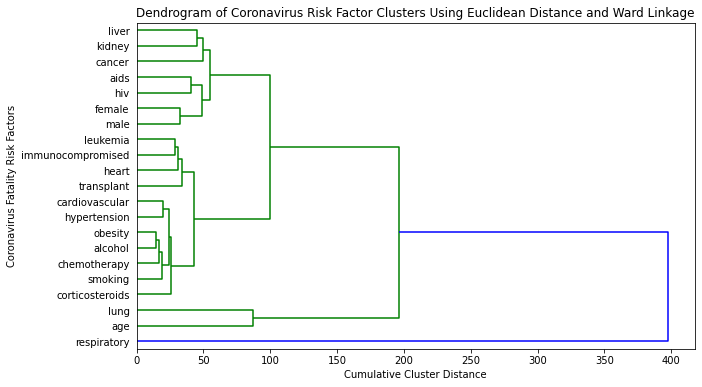

In [0]:
# plot for dendrogram using euclidean distance and ward linkage
figure(figsize=(10,6))
dendrogram = sch.dendrogram(sch.linkage(euclidean, method='ward'), labels=list(euclidean.columns), orientation='right')
plt.title('Dendrogram of Coronavirus Risk Factor Clusters Using Euclidean Distance and Ward Linkage')
plt.xlabel('Cumulative Cluster Distance')
plt.ylabel('Coronavirus Fatality Risk Factors')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


Text(0, 0.5, 'Coronavirus Fatality Risk Factors')

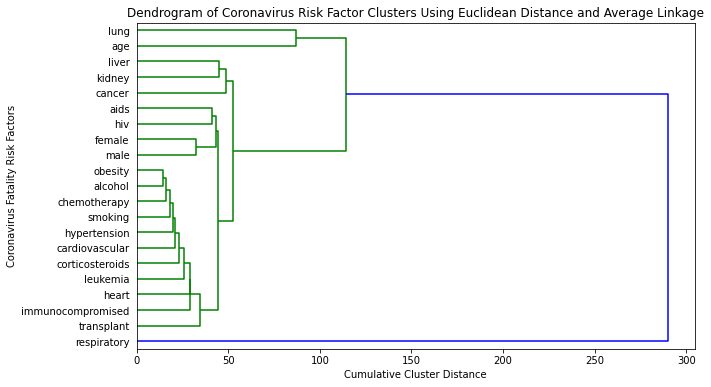

In [0]:
# plot for dendrogram using euclidean distance and average linkage
figure(figsize=(10,6))
dendrogram = sch.dendrogram(sch.linkage(euclidean, method='average'), labels=list(euclidean.columns), orientation='right')
plt.title('Dendrogram of Coronavirus Risk Factor Clusters Using Euclidean Distance and Average Linkage')
plt.xlabel('Cumulative Cluster Distance')
plt.ylabel('Coronavirus Fatality Risk Factors')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


Text(0, 0.5, 'Coronavirus Fatality Risk Factors')

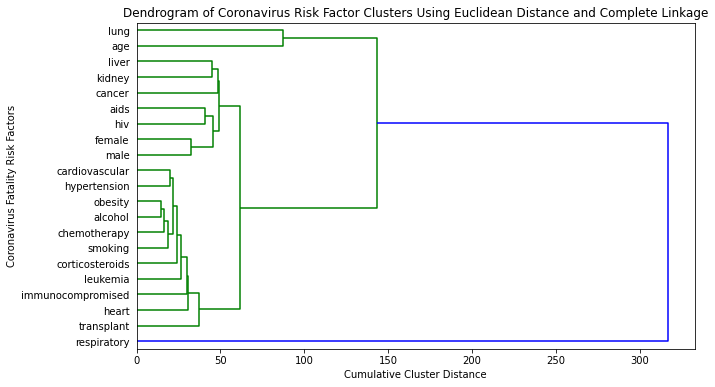

In [0]:
# plot for dendrogram using euclidean distance and complete linkage
figure(figsize=(10,6))
dendrogram = sch.dendrogram(sch.linkage(euclidean, method='complete'), labels=list(euclidean.columns), orientation='right')
plt.title('Dendrogram of Coronavirus Risk Factor Clusters Using Euclidean Distance and Complete Linkage')
plt.xlabel('Cumulative Cluster Distance')
plt.ylabel('Coronavirus Fatality Risk Factors')

As observed in the three dendrograms above, the clustering results of all three plots do not give much insight into the risk factor groups. For all three plots, the factor 'respiratory' is shown to have a much higher distance than the other risk factors. This is likely due to the fact that Euclidean distance compares the vector magnitudes of each risk factor, and the word 'respiratory' has much higher magnitude than the others since it exists in many more paper abstracts (over 7,000). On the other hand, cosine similarity captures the orientation (or angle) of two vectors, and is not influenced by the word frequencies. Therefore, we will explore whether cosine similarity can be more useful for our analysis. 

In [0]:
# calculates pairwise cosine similarity and forms the distance matrix
cosine = pd.DataFrame(
    cosine_similarity(df_risk.T),
    columns = df_risk.T.index,
    index = df_risk.T.index)

cosine

,male,female,age,hypertension,heart,cardiovascular,kidney,liver,lung,respiratory,cancer,chemotherapy,hiv,aids,transplant,immunocompromised,smoking,alcohol,obesity,corticosteroids,leukemia
male,1.000000,0.449019,0.245111,0.077238,0.065711,0.037949,0.036279,0.037360,0.061490,0.098563,0.019662,0.000000,0.014028,0.013538,0.010120,0.005909,0.036286,0.018503,0.017107,0.029428,0.039940
female,0.449019,1.000000,0.210347,0.054595,0.047962,0.029729,0.027780,0.043803,0.051300,0.070829,0.016004,0.000000,0.020186,0.022727,0.002831,0.009919,0.025381,0.000000,0.019146,0.020584,0.022350
age,0.245111,0.210347,1.000000,0.087905,0.091983,0.062001,0.037619,0.036761,0.073601,0.280936,0.029204,0.025789,0.020223,0.020601,0.035255,0.038330,0.085003,0.005928,0.038363,0.068937,0.019192
hypertension,0.077238,0.054595,0.087905,1.000000,0.207383,0.244853,0.088549,0.017936,0.060865,0.047069,0.025229,0.000000,0.000000,0.004550,0.010202,0.005957,0.064018,0.024872,0.103482,0.014834,0.000000
heart,0.065711,0.047962,0.091983,0.207383,1.000000,0.182838,0.100113,0.090758,0.088720,0.057339,0.048127,0.000000,0.005680,0.006395,0.039436,0.020932,0.051420,0.017480,0.064647,0.026063,0.000000
cardiovascular,0.037949,0.029729,0.062001,0.244853,0.182838,1.000000,0.075473,0.033486,0.048400,0.040033,0.050468,0.000000,0.003772,0.012741,0.014286,0.011121,0.034149,0.023218,0.128802,0.013848,0.000000
kidney,0.036279,0.027780,0.037619,0.088549,0.100113,0.075473,1.000000,0.156693,0.114352,0.062394,0.023700,0.005083,0.013286,0.012822,0.050315,0.019585,0.012887,0.005841,0.027003,0.006967,0.025217
liver,0.037360,0.043803,0.036761,0.017936,0.090758,0.033486,0.156693,1.000000,0.112465,0.038451,0.070979,0.014207,0.014147,0.009955,0.058043,0.007821,0.004002,0.027212,0.040255,0.006492,0.014685
lung,0.061490,0.051300,0.073601,0.060865,0.088720,0.048400,0.114352,0.112465,1.000000,0.259472,0.088218,0.038688,0.014447,0.023773,0.101009,0.045871,0.080486,0.017101,0.018973,0.061194,0.009228
respiratory,0.098563,0.070829,0.280936,0.047069,0.057339,0.040033,0.062394,0.038451,0.259472,1.000000,0.029435,0.031760,0.040736,0.048187,0.080067,0.101859,0.067689,0.025391,0.030812,0.079504,0.019697


Text(0, 0.5, 'Coronavirus Fatality Risk Factors')

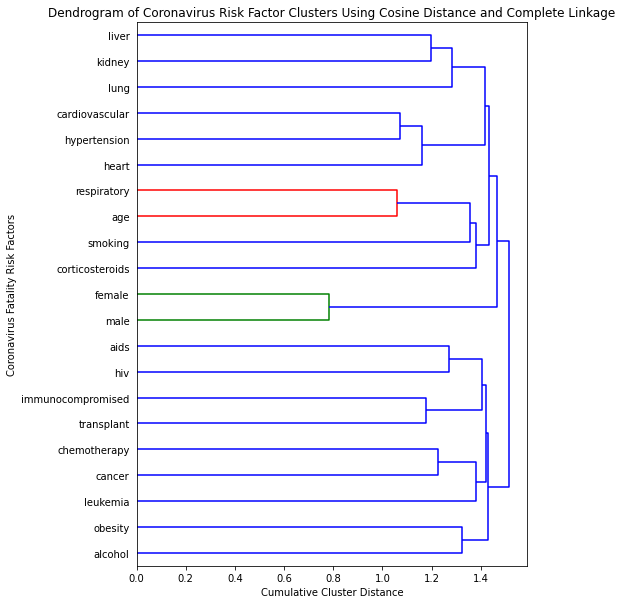

In [0]:
figure(figsize=(7,10))
dendrogram = sch.dendrogram(sch.linkage(cosine, method='complete'), labels=list(cosine.columns), orientation='right')
plt.title('Dendrogram of Coronavirus Risk Factor Clusters Using Cosine Distance and Complete Linkage')
plt.xlabel('Cumulative Cluster Distance')
plt.ylabel('Coronavirus Fatality Risk Factors')

Text(0, 0.5, 'Coronavirus Fatality Risk Factors')

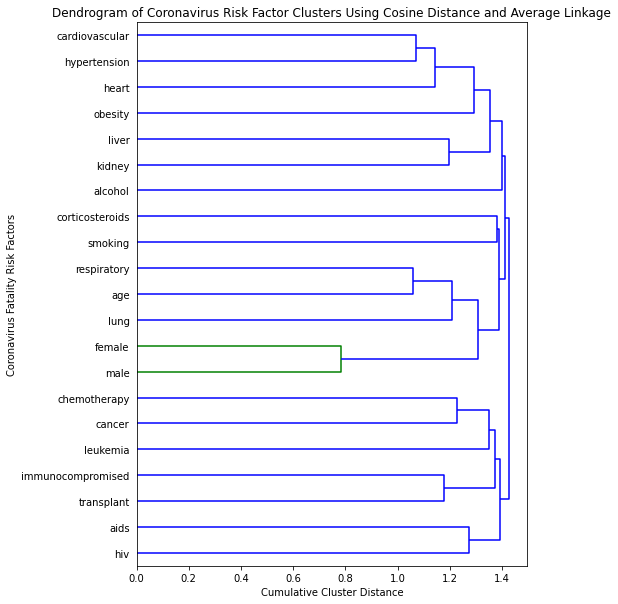

In [0]:
figure(figsize=(7,10))
dendrogram = sch.dendrogram(sch.linkage(cosine, method='average'), labels=list(cosine.columns), orientation='right')
plt.title('Dendrogram of Coronavirus Risk Factor Clusters Using Cosine Distance and Average Linkage')
plt.xlabel('Cumulative Cluster Distance')
plt.ylabel('Coronavirus Fatality Risk Factors')

Text(0, 0.5, 'Coronavirus Fatality Risk Factors')

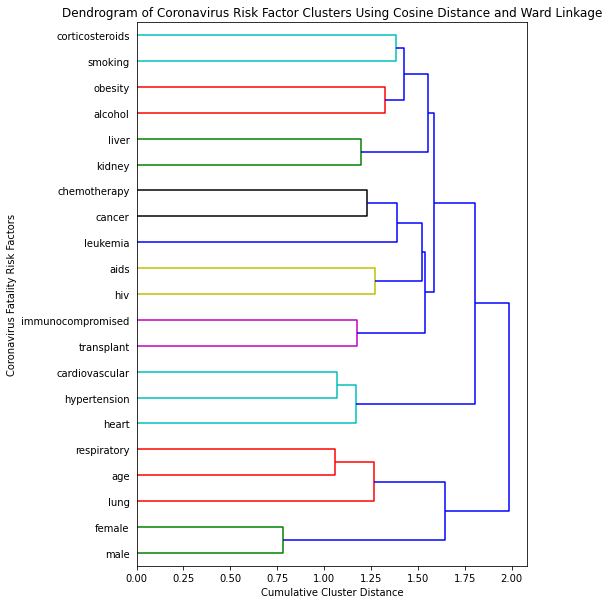

In [0]:
figure(figsize=(7,10))
dendrogram = sch.dendrogram(sch.linkage(cosine, method='ward'), labels=list(cosine.columns), orientation='right')
plt.title('Dendrogram of Coronavirus Risk Factor Clusters Using Cosine Distance and Ward Linkage')
plt.xlabel('Cumulative Cluster Distance')
plt.ylabel('Coronavirus Fatality Risk Factors')

As seen in the three dendrograms with cosine similarity above, the dendrogram with ward linkage demonstrates the clearest cumulative distance separation between the cluster groups. This is likely due to the fact that ward linkage calculates distances based on all of the smaller clusters (sum of squared differences in distances), instead of a single one (farthest or closest). As such, we will use the results of this dendrogram to carry forward the analysis.

The dendrogram below uses color threshold to better visualize larger risk groups. 

Text(0, 0.5, 'Coronavirus Fatality Risk Factors')

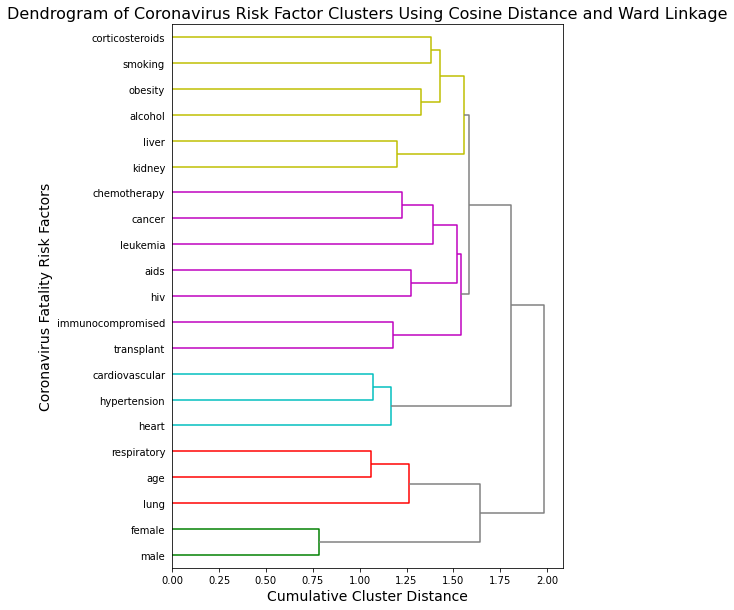

In [0]:
# use colors to visualize larger groups
figure(figsize=(7,10))
dendrogram = sch.dendrogram(sch.linkage(cosine, method='ward'), labels=list(cosine.columns), orientation='right', color_threshold=1.56, above_threshold_color='grey')
plt.title('Dendrogram of Coronavirus Risk Factor Clusters Using Cosine Distance and Ward Linkage', fontsize=16)
plt.xlabel('Cumulative Cluster Distance', fontsize=14)
plt.ylabel('Coronavirus Fatality Risk Factors', fontsize=14)

# 4. Deriving insights about policy and guidance to tackle the outbreak based on model findings

From now on we will only refer to the dendrogram above using cosine distance and ward linkage.

## 4.1 Interpreting Clustering Results of Risk Factors


Based on the color thresholds, the risk factor groups can be divided into the following groups, from yellow to green: 

  **1. Indirect causes of immunocompromised conditions (yellow):** 

    - life style (alcohol, smoking, obesity)
    - chronic diseases (liver, kidney)
    - drug uses (corticosteroids)

**2. Direct causes of immunocompromised conditions (purple):**

    - cancer (chemotherapy, leukemia)
    - HIV (aids)
    - organ transplant

**3. Cardiovascular Conditions (blue):**

    - chronic heart disease
    - hypertension

**4. Respiratory Conditions and Age (red):**

    - chronic lung disease
    - age

**5. Gender (green):**

    - male
    - female

There is one further level of clustering (as shown in grey) which can be interpreted as follows:


**1. Immunocompromised Conditions (yellow and purple)**

**2. Cardiovascular Conditions (blue)**

**3. Respiratory and Personal Factors (red and green)**

## 4.2 Visualizing Clustering Results with Word Frequencies (Section 2.3) to Understand Risk Severities

To gain an understanding of the severity of each risk factor group, we will visualize by combining the clustering results with the word frequency bar plot in section 2.3. Note that some groups have been divided into subgroups (e.g. Gender to Male/Female) to make more specific recommendations in later sections.

Text(0.5, 1.0, 'Number of Paper Abstracts Containing Each Risk Factor Group')

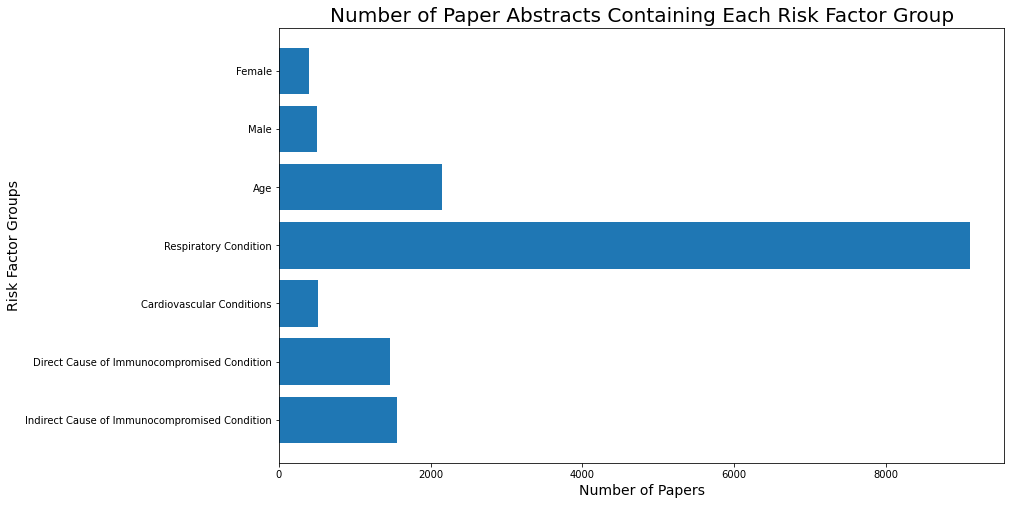

In [0]:
#plotting risk groups against the number of appearances in paper abstracts
group_count = [1552, 1465, 509, 9105, 2148, 496, 396]
groups = ['Indirect Cause of Immunocompromised Condition', 'Direct Cause of Immunocompromised Condition', 'Cardiovascular Conditions', 'Respiratory Condition', 'Age', 'Male', 'Female']
figure(figsize=(13, 8))
plt.barh(groups, group_count)
plt.xlabel('Number of Papers', fontsize=14)
plt.ylabel('Risk Factor Groups', fontsize=14)
plt.title('Number of Paper Abstracts Containing Each Risk Factor Group', fontsize=20)

From the plot presented above, we can see that the risk group of Respiratory Conditions has an overwhelming amount of presence compared to the other groups, indicating that this is the risk group with the highest risk. Also worth noting is that Age and Immunocompromised Conditions (direct and indirect) also deserve a great deal of attention. From the gender's perspective, Males seem to be at higher risk than Females, though not significantly more so. Cardiovascular conditions are ranked last.

## 4.3 Insights about policy and guidance to tackle the outbreak from various perspectives based on model findings.

### 4.3.1 Hospitals 

All of the risk groups of coronaviruses as defined have varying levels of severities, but all can lead to respiratory disfunction which can ultimately cause death. Therefore, it is essential that hospitals be properly equipped with tools to treat patients with respiratory illnesses, such as respirators. Also, it is recommended that hospitals incorporate preliminary screenings for existing underlying health conditions based on the model results in order to give vulnerable patients the extra attention they need. 

- As indicated from the model results, patients with existing respiratory conditions such as pneumonia should be treated with extreme caution, and should be placed into intensive care as deemed necessary. 

- Elderly patients presented with coronavirus simptoms (such as cough and fever) should be given extra attention in terms of monitoring as their condition can worsen at a faster pace. 

- Similar to elderly patients, patients with immunocompromised conditions such as patients undergoing chemotherapy should excercise extra caution for proper monitoring as well as prevention of infections. 



### 4.3.2 Governments

Governments should inform its citizens via the proper channels (government websites, advertising, etc) of the groups of people who should be extra cautious when it comes to infection prevention. Recommendations based on the model results: 

- Elderly citizens should limit contact with other people, including family members. 

- People with underlying health conditions, especially those with respiratory conditions, also need to limit contact with the outside, and should contact 911 or other emergency hotlines if they experience the development and worsening of coronavirus symptoms.

- To maintain a person's general health (and immune system), it is recommended to take-on a healthy lifestyle, including incorporating a health diet, less alcohol consumption, and less smoking.

- All of the vulnerable groups of people should exercise proper personal protections around other people, such as wearing a face mask, maintaing proper hand sanitation and social distance.

### 4.3.3 Industries

These recommendations should be made to industries by the government (local and federal). Since respiratory conditions is the most severe risk group, the recommendations below are focused mainly on the supply of essential tools for dealing with this risk group:

- Current producers of health care equipments should ramp up the production of essential gears such as respirators and face masks.

- Other manufacturers should get involved in the same process in ways that they can. 